In [1]:
import os
import cv2
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
#Loading images
data_dir = Path("C:/captcha/")
images = list(data_dir.glob("*.png"))

In [3]:
# 이미지 전처리
#Padding func
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT

# Calculate the padding values based on a percentage of the source image dimensions
def pad(src):
    # 이미지 위아래 패딩 0.05 추가
    top = int(0.05 * src.shape[0])  # shape[0] = rows
    bottom = top
    # 이미지 양옆 패딩 0.15 추가
    left = int(0.15 * src.shape[1])  # shape[1] = cols
    right = left

    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des) # 원본 이미지 유지 및 패딩영역 흰색으로 만들기

In [4]:
x=[] #image
y=[] #label

for image in images:
    im=cv2.imread(str(image),0) # 이미지 파일 흑백으로 읽어옴
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5) # 임계값 처리
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y.append(s[-9+i])

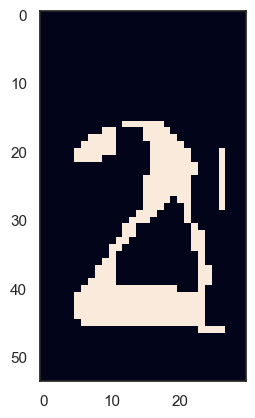

In [21]:
plt.imshow(x[65]) # 이미지를 플롯으로 출력 

In [22]:
y[65] # 해당 이미지의 label 출력

'2'

In [7]:
x=np.array(x)
y=np.array(y)

In [8]:
(unique, counts) = np.unique(y, return_counts=True) # 빈도수 구하기
frequencies = np.asarray((unique, counts)).T  # 레이블과 빈도수 매칭한 2차원 배열 생성

print(frequencies) # 각 label 빈도수 출력

[['2' '265']
 ['3' '267']
 ['4' '284']
 ['5' '281']
 ['6' '259']
 ['7' '258']
 ['8' '264']
 ['b' '240']
 ['c' '262']
 ['d' '259']
 ['e' '235']
 ['f' '271']
 ['g' '271']
 ['m' '275']
 ['n' '525']
 ['p' '253']
 ['w' '235']
 ['x' '264']
 ['y' '232']]


In [9]:
data=np.reshape(x,(-1,54,30,1)) # 4차원 배열로 변환

train = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y:
    i=l.index(j)
    a=[]
    for r in range(19): # l리스트와 매칭되는 인덱스 생성하기 위한것
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    train.append(a) # one-hot 인코딩된 레이블(a)를 리스트에 저장
train=np.array(train) 

In [10]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [11]:
# 모델 구성(CNN)
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (54,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

model.summary() # 모델의 요약 정보

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 30, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 30, 16)        6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 15, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 15, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 15, 32)        12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 15, 32)        25632     
                                                        

In [12]:
# train, test 분류(test set: 10%)
X_train, X_test, Y_train, Y_test = train_test_split(data, train, test_size = 0.1, random_state= 2, shuffle = False)
X_train=X_train/255.0
X_test=X_test/255.0

In [13]:
epochs = 30
batch_size = 86

model.compile(optimizer = "RMSprop" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
# 모델 훈련(validation: 20%)
history = model.fit(X_train,Y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 1)

Epoch 1/30
44/44 [==============================] - 3s 58ms/step - loss: 2.4376 - accuracy: 0.2348 - val_loss: 1.6175 - val_accuracy: 0.4818
Epoch 2/30
44/44 [==============================] - 3s 62ms/step - loss: 1.2852 - accuracy: 0.5962 - val_loss: 0.8934 - val_accuracy: 0.6827
Epoch 3/30
44/44 [==============================] - 2s 50ms/step - loss: 0.8332 - accuracy: 0.7393 - val_loss: 1.0013 - val_accuracy: 0.6389
Epoch 4/30
44/44 [==============================] - 2s 54ms/step - loss: 0.6441 - accuracy: 0.8056 - val_loss: 0.5039 - val_accuracy: 0.8226
Epoch 5/30
44/44 [==============================] - 2s 54ms/step - loss: 0.4805 - accuracy: 0.8520 - val_loss: 0.6022 - val_accuracy: 0.7639
Epoch 6/30
44/44 [==============================] - 3s 58ms/step - loss: 0.4242 - accuracy: 0.8747 - val_loss: 0.3871 - val_accuracy: 0.8408
Epoch 7/30
44/44 [==============================] - 2s 54ms/step - loss: 0.3643 - accuracy: 0.8897 - val_loss: 0.3390 - val_accuracy: 0.8686
Epoch 8/30
44

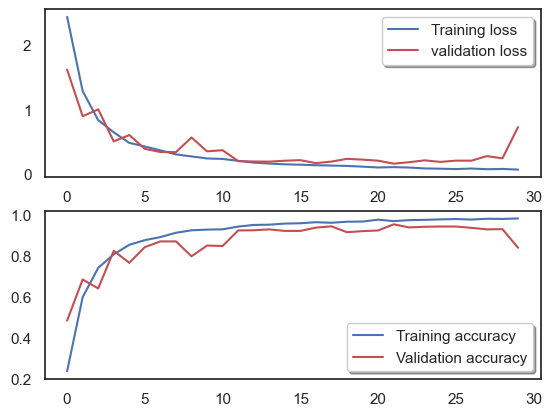

In [15]:
# 학습과정 및 검증의 손실과 정확도 그래프 출력
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
# 모델 성능 평가
score = model.evaluate(X_test, Y_test, verbose = 0)

print(f"Loss: {score[0]:.3f}")
print(f"Accuracy: {score[1] * 100:.3f}%")

Loss: 0.131
Accuracy: 95.962%


In [17]:
# test data 예측
predictions = model.predict(X_test)

t_label = [l[np.argmax(Y_test[i])] for i in range(len(Y_test))]
p_label = [l[np.argmax(Y_test[i])] for i in range(len(predictions))]


true_label, pred_label = "", ""
true_labels, pred_labels, results = [], [], []

for i in range(len(X_test)):
    true_label += t_label[i]
    pred_label += p_label[i]

    if i % 5 == 4:
        res = "Correct" if t_label == p_label else "Incorrect"
        true_labels.append(true_label), pred_labels.append(pred_label), results.append(res)

        print(f"Image {i//5 + 1} - True Label: {true_label}, Predicted Label: {pred_label}, Result: {res}")

        true_label, pred_label = "", ""

17/17 [==============================] - 0s 8ms/step
Image 1 - True Label: x2cnn, Predicted Label: x2cnn, Result: Correct
Image 2 - True Label: x347n, Predicted Label: x347n, Result: Correct
Image 3 - True Label: x362g, Predicted Label: x362g, Result: Correct
Image 4 - True Label: x37bf, Predicted Label: x37bf, Result: Correct
Image 5 - True Label: x38fn, Predicted Label: x38fn, Result: Correct
Image 6 - True Label: x3deb, Predicted Label: x3deb, Result: Correct
Image 7 - True Label: x3fwf, Predicted Label: x3fwf, Result: Correct
Image 8 - True Label: x44n4, Predicted Label: x44n4, Result: Correct
Image 9 - True Label: x458w, Predicted Label: x458w, Result: Correct
Image 10 - True Label: x4f7g, Predicted Label: x4f7g, Result: Correct
Image 11 - True Label: x4gg5, Predicted Label: x4gg5, Result: Correct
Image 12 - True Label: x4pnp, Predicted Label: x4pnp, Result: Correct
Image 13 - True Label: x5f54, Predicted Label: x5f54, Result: Correct
Image 14 - True Label: x5nyn, Predicted Label:

In [18]:
label_dict = {"True Label": true_labels, "Predicted Label":  pred_labels, "Result": results}

df =  pd.DataFrame(label_dict)
df.to_csv("./label_dictionary.csv", index=False)